In [1]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from utils.stats import calculate_sensitivity, median_confidence_interval, calculate_subgroup_metric_median_stats, friedman_with_posthoc

In [2]:
def aggregate_csvs(csvs):
    dfs = []
    for c in csvs:
        df_ = pd.read_csv(c)
        df_['fold'] = c.split('_')[-1].split('.')[0]
        dfs.append(df_)
    df_all = pd.concat(dfs, axis=0)
    return df_all

In [3]:
def plot_metric_by_quartile(df, metric_col, figsize=(18, 9), palette='Set2', 
                           freeze_labels=None, quartile_col='Volume Quartile', y_lim=None, model_list=None,
                           highlight_models=None, highlight_color='red', highlight_label=None):
    """
    Plot any metric with confidence intervals using freeze as hue and quartiles as subplots.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 'model', 'freeze', quartile_col, 
        metric_col, 'ci_lower', 'ci_upper'
    metric_col : str
        Name of the metric column to plot (e.g., 'Sensitivity', 'Specificity', 'AUC')
    figsize : tuple, default (15, 10)
        Figure size (width, height)
    palette : str, default 'Set2'
        Color palette for different freeze values
    freeze_labels : dict, optional
        Custom labels for freeze values {0: 'label0', 1: 'label1'}
        Default: {1: 'Linear Probing', 0: 'Fine-tuning'}
    quartile_col : str, default 'Volume Quartile'
        Name of the quartile/grouping column
    y_lim : tuple, optional
        Y-axis limits as (min, max). If None, uses automatic limits.
    model_list : list, optional
        Specific list of models to plot. If None, uses all models from data.
    highlight_models : list or str, optional
        Models to highlight with different color. Can be:
        - 'last': highlight only the last model
        - list of model names: highlight specific models
        - None: no highlighting
    highlight_color : str, default 'red'
        Color to use for highlighted model bars
    highlight_label : str, optional
        Custom label for highlighted models in legend. If None, auto-generates label
    
    Returns:
    --------
    fig, axes : matplotlib figure and axes objects
    """
    
    # Default freeze labels
    if freeze_labels is None:
        freeze_labels = {1: 'Linear Probing', 0: 'Fine-tuning'}
    
    # Get unique quartiles and freeze values
    quartiles = sorted(df[quartile_col].unique())
    freeze_values = [1, 0]  # sorted(df['freeze'].unique())
    
    # Create subplots
    n_quartiles = len(quartiles)
    n_cols = min(2, n_quartiles)  # Max 3 columns
    n_rows = (n_quartiles + n_cols - 1) // n_cols  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False, sharey=True, dpi=300)
    
    # Create color palette for freeze values
    colors = sns.color_palette(palette, len(freeze_values))
    color_map = dict(zip(freeze_values, colors))
    
    # Determine which models to highlight
    if model_list is None:
        all_models = sorted(df['model'].unique())
    else:
        all_models = model_list
    
    models_to_highlight = []
    if highlight_models == 'last':
        models_to_highlight = [all_models[-1]]
    elif isinstance(highlight_models, list):
        models_to_highlight = highlight_models
    elif isinstance(highlight_models, str) and highlight_models != 'last':
        models_to_highlight = [highlight_models]
    
    # Plot for each quartile
    for idx, quartile in enumerate(quartiles):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        # Filter data for current quartile
        quartile_data = df[df[quartile_col] == quartile].copy()
        
        # Group by model and freeze values for plotting
        if model_list is None:
            models = sorted(quartile_data['model'].unique())
        else:
            models = model_list

        x_positions = np.arange(len(models))
        
        # Width for grouped bars
        width = 0.8 / len(freeze_values)
        
        for i, freeze_val in enumerate(freeze_values):
            freeze_data = quartile_data[quartile_data['freeze'] == freeze_val]
            
            # Get data for each model
            model_metrics = []
            model_ci_lower = []
            model_ci_upper = []
            model_positions = []
            bar_colors = []
            
            for model in models:
                model_data = freeze_data[freeze_data['model'] == model]
                if not model_data.empty:
                    model_metrics.append(model_data[metric_col].iloc[0])
                    model_ci_lower.append(model_data['ci_lower'].iloc[0])
                    model_ci_upper.append(model_data['ci_upper'].iloc[0])
                    model_positions.append(x_positions[models.index(model)] + i * width - width * (len(freeze_values) - 1) / 2)
                    
                    # Determine color for this bar
                    if model in models_to_highlight:
                        bar_colors.append(highlight_color)
                    else:
                        bar_colors.append(color_map[freeze_val])
                else:
                    # Handle missing data
                    model_metrics.append(0)
                    model_ci_lower.append(0)
                    model_ci_upper.append(0)
                    model_positions.append(x_positions[models.index(model)] + i * width - width * (len(freeze_values) - 1) / 2)
                    bar_colors.append(color_map[freeze_val])
            
            # Calculate error bars (distance from center to bounds)
            yerr_lower = np.array(model_metrics) - np.array(model_ci_lower)
            yerr_upper = np.array(model_ci_upper) - np.array(model_metrics)
            yerr = [yerr_lower, yerr_upper]
            
            # Get freeze label for legend
            freeze_label = freeze_labels.get(freeze_val, f'Freeze {freeze_val}')
            
            # Plot bars with error bars
            bars = ax.bar(model_positions, model_metrics, width, 
                         label=freeze_label, 
                         color=bar_colors, 
                         alpha=0.8, 
                         capsize=3)
            
            # Add error bars
            ax.errorbar(model_positions, model_metrics, 
                       yerr=yerr, fmt='none', 
                       color='black', capsize=3, capthick=1)
        
        # Customize subplot
        if idx % n_cols == 0:  # First column
            ax.set_ylabel(metric_col, fontsize=14)
        
        ax.set_title(f'{quartile_col}: {quartile}', fontsize=14)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(models, rotation=45, ha='right', fontsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Create legend with freeze colors and highlighted models
        legend_elements = []
        
        # Add freeze legend entries
        for freeze_val in freeze_values:
            freeze_label = freeze_labels.get(freeze_val, f'Freeze {freeze_val}')
            legend_elements.append(plt.Rectangle((0,0),1,1, 
                                               facecolor=color_map[freeze_val], 
                                               alpha=0.8, 
                                               label=freeze_label))
        
        # Add highlighted models legend entry if applicable
        if models_to_highlight:
            if highlight_label:
                legend_label = highlight_label
            elif len(models_to_highlight) == 1 and highlight_models == 'last':
                legend_label = f"Highlighted ({models_to_highlight[0]})"
            elif len(models_to_highlight) == 1:
                legend_label = f"Highlighted ({models_to_highlight[0]})"
            else:
                legend_label = "Highlighted Models"
            
            legend_elements.append(plt.Rectangle((0,0),1,1, 
                                               facecolor=highlight_color, 
                                               alpha=0.8, 
                                               label=legend_label))
        
        ax.legend(handles=legend_elements, loc='lower right', fontsize=14)
        
        # Set y-axis limits if specified
        if y_lim is not None:
            ax.set_ylim(y_lim)
        
        # Add value labels on bars (optional)
        for i, freeze_val in enumerate(freeze_values):
            freeze_data = quartile_data[quartile_data['freeze'] == freeze_val]
            for j, model in enumerate(models):
                model_data = freeze_data[freeze_data['model'] == model]
                if not model_data.empty:
                    metric_value = model_data[metric_col].iloc[0]
                    upper = model_data['ci_upper'].iloc[0]
                    x_pos = x_positions[j] + i * width - width * (len(freeze_values) - 1) / 2
                    ax.text(x_pos, upper + 0.005, f'{metric_value:.2f}', 
                           ha='center', va='bottom', fontsize=10, rotation=0)
    
    # Hide empty subplots
    total_subplots = n_rows * n_cols
    for idx in range(n_quartiles, total_subplots):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, axes

In [4]:
cla_csvs = glob('./results/*_ptx_cla_*.csv')
len(cla_csvs)

85

In [5]:
df = aggregate_csvs(cla_csvs)
df['ImagePath'] = df.paths.apply(lambda x: x.split('/')[-1])
df

,logits,labels,probs,paths,freeze,model,task,target,fold,ImagePath
0,-0.185285,0.0,0.453811,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,1,MedSigLIP,classification,pneumothorax,4,1.2.276.0.7230010.3.1.4.8323329.5591.151787518...
1,1.573389,1.0,0.828266,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,1,MedSigLIP,classification,pneumothorax,4,1.2.276.0.7230010.3.1.4.8323329.4577.151787518...
2,-2.100420,0.0,0.109056,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,1,MedSigLIP,classification,pneumothorax,4,1.2.276.0.7230010.3.1.4.8323329.5794.151787519...
3,2.737088,1.0,0.939180,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,1,MedSigLIP,classification,pneumothorax,4,1.2.276.0.7230010.3.1.4.8323329.1263.151787516...
4,-2.491471,0.0,0.076458,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,1,MedSigLIP,classification,pneumothorax,4,1.2.276.0.7230010.3.1.4.8323329.12585.15178752...
...,...,...,...,...,...,...,...,...,...,...
947,-2.746587,0.0,0.060280,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,0,SegFormer,classification,pneumothorax,1,1.2.276.0.7230010.3.1.4.8323329.32229.15178751...
948,2.968152,1.0,0.951114,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,0,SegFormer,classification,pneumothorax,1,1.2.276.0.7230010.3.1.4.8323329.10358.15178752...
949,3.362121,1.0,0.966499,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,0,SegFormer,classification,pneumothorax,1,1.2.276.0.7230010.3.1.4.8323329.13159.15178752...
950,-1.108883,0.0,0.248079,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,0,SegFormer,classification,pneumothorax,1,1.2.276.0.7230010.3.1.4.8323329.3397.151787517...


In [6]:
ptx_vol = pd.read_csv('./inputs/ptx_volume_pct.csv')
ptx_vol

,ImagePath,Volume,Volume Quartile
0,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,0.898170,Q3
1,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,1.129913,Q3
2,1.2.276.0.7230010.3.1.4.8323329.1314.151787516...,2.773190,Q4
3,1.2.276.0.7230010.3.1.4.8323329.4440.151787518...,0.237083,Q1
4,1.2.276.0.7230010.3.1.4.8323329.4982.151787518...,0.498962,Q2
...,...,...,...
2374,1.2.276.0.7230010.3.1.4.8323329.3335.151787517...,0.377274,Q2
2375,1.2.276.0.7230010.3.1.4.8323329.1805.151787516...,0.655651,Q2
2376,1.2.276.0.7230010.3.1.4.8323329.32260.15178751...,0.727844,Q2
2377,1.2.276.0.7230010.3.1.4.8323329.32459.15178751...,0.522995,Q2


In [7]:
tube = pd.read_csv('/mnt/NAS3/datasets/external/SIIM_ACR_Pneumothorax/MDai_Label_SIIM.csv')
tube['ImagePath'] = tube.ImagePath.apply(lambda x: x.split('/')[-1][:-4]+'.png')
tube = tube[['ImagePath','ChestTube']]
tube

,ImagePath,ChestTube
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,0
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,0
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,0
3,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,0
4,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,0
...,...,...
10670,1.2.276.0.7230010.3.1.4.8323329.5792.151787519...,0
10671,1.2.276.0.7230010.3.1.4.8323329.5793.151787519...,0
10672,1.2.276.0.7230010.3.1.4.8323329.5794.151787519...,0
10673,1.2.276.0.7230010.3.1.4.8323329.5795.151787519...,1


In [8]:
df = df.merge(ptx_vol, on='ImagePath', how='left')
df = df.merge(tube, on='ImagePath', how='left')
df['preds'] = (df.probs>=0.5).astype(int)
df['results'] = df.apply(lambda x: 'FN' if (x.preds==0) & (x.labels==1) else 'TP' if (x.preds==1) & (x.labels==1) else 'FP' if (x.preds==1) & (x.labels==0) else 'TN', axis=1)
df['Vol-Tube'] = df.apply(lambda x: f'{x['Volume Quartile']}-{x['ChestTube']}', axis=1) 
df

,logits,labels,probs,paths,freeze,model,task,target,fold,ImagePath,Volume,Volume Quartile,ChestTube,preds,results,Vol-Tube
0,-0.185285,0.0,0.453811,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,1,MedSigLIP,classification,pneumothorax,4,1.2.276.0.7230010.3.1.4.8323329.5591.151787518...,NaN,NaN,0,0,TN,nan-0
1,1.573389,1.0,0.828266,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,1,MedSigLIP,classification,pneumothorax,4,1.2.276.0.7230010.3.1.4.8323329.4577.151787518...,0.311565,Q1,1,1,TP,Q1-1
2,-2.100420,0.0,0.109056,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,1,MedSigLIP,classification,pneumothorax,4,1.2.276.0.7230010.3.1.4.8323329.5794.151787519...,NaN,NaN,0,0,TN,nan-0
3,2.737088,1.0,0.939180,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,1,MedSigLIP,classification,pneumothorax,4,1.2.276.0.7230010.3.1.4.8323329.1263.151787516...,2.875519,Q4,1,1,TP,Q4-1
4,-2.491471,0.0,0.076458,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,1,MedSigLIP,classification,pneumothorax,4,1.2.276.0.7230010.3.1.4.8323329.12585.15178752...,NaN,NaN,0,0,TN,nan-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80881,-2.746587,0.0,0.060280,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,0,SegFormer,classification,pneumothorax,1,1.2.276.0.7230010.3.1.4.8323329.32229.15178751...,NaN,NaN,0,0,TN,nan-0
80882,2.968152,1.0,0.951114,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,0,SegFormer,classification,pneumothorax,1,1.2.276.0.7230010.3.1.4.8323329.10358.15178752...,0.070763,Q1,1,1,TP,Q1-1
80883,3.362121,1.0,0.966499,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,0,SegFormer,classification,pneumothorax,1,1.2.276.0.7230010.3.1.4.8323329.13159.15178752...,0.233173,Q1,1,1,TP,Q1-1
80884,-1.108883,0.0,0.248079,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,0,SegFormer,classification,pneumothorax,1,1.2.276.0.7230010.3.1.4.8323329.3397.151787517...,NaN,NaN,0,0,TN,nan-0


In [9]:
df_sub = df[(df.labels==1.0)]

In [10]:
models = ['Ark+', 'BiomedCLIP', 'CheXagent', 'MedImageInsights', 'MedSigLIP', 'RAD-DINO', 'DINOv2', 'SigLIP2', 'SegFormer']
colors = sns.color_palette('Set2', 3)

/mnt/NAS3/homes/fli40/FM_evaluation/utils/stats.py:163: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subgroup_metric = df_sub.groupby(['fold', 'model', 'freeze', groupby_column]).apply(metric_function)


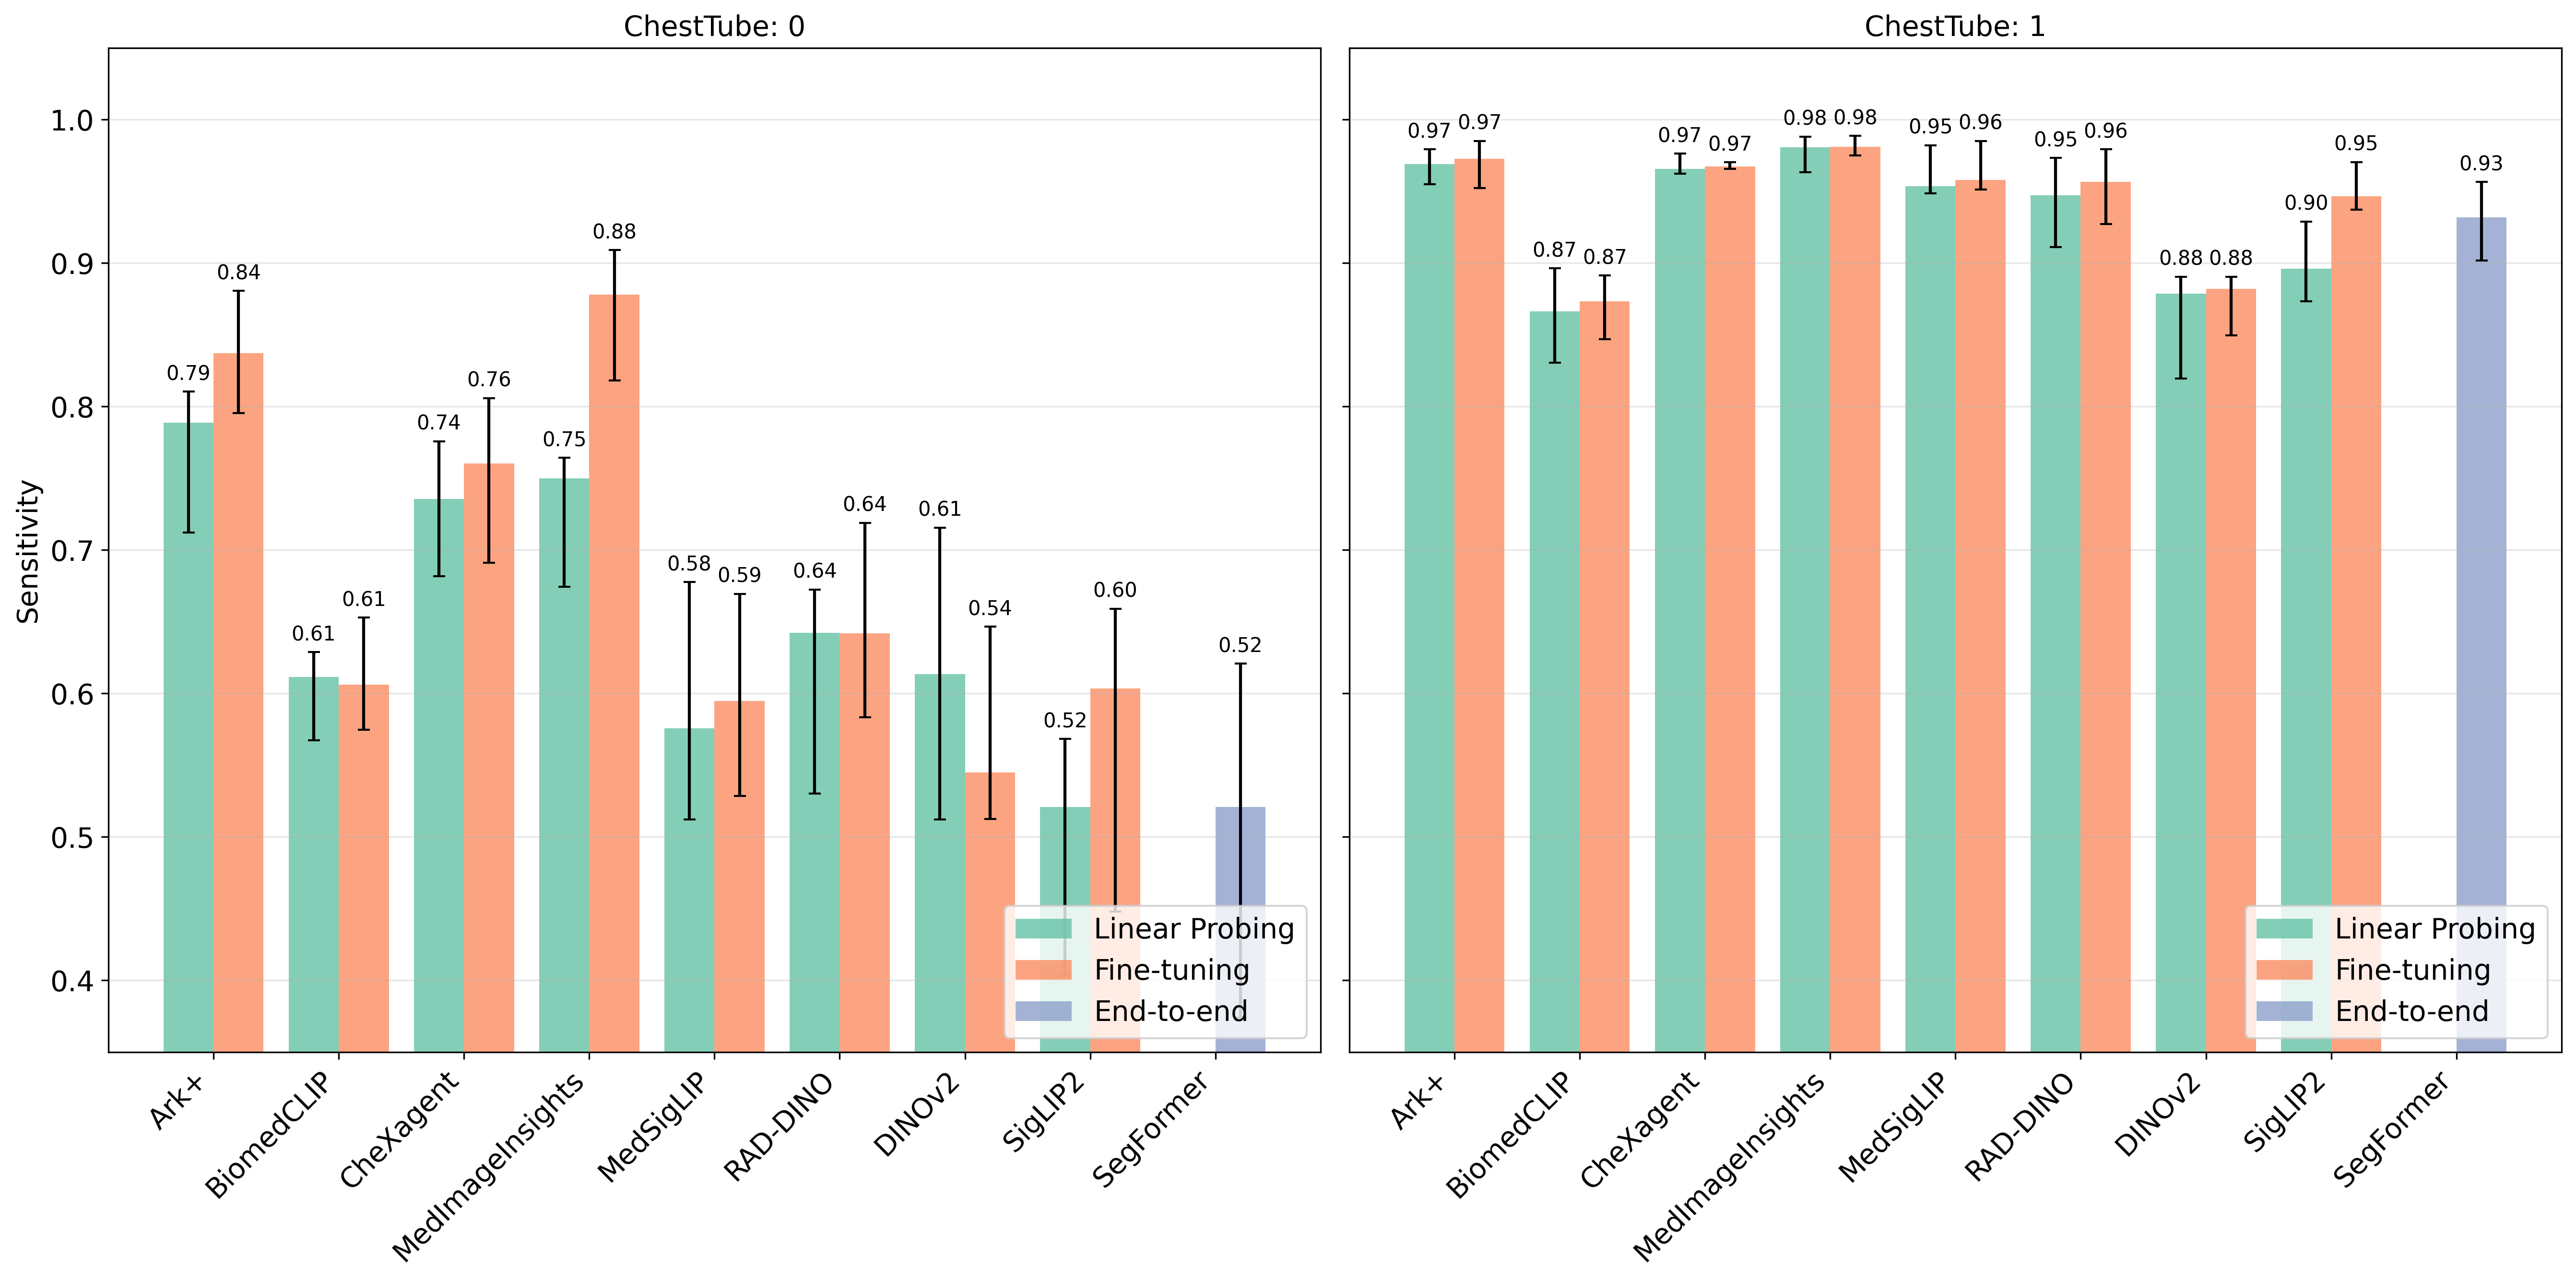

In [11]:
avg_sensitivity_tube = calculate_subgroup_metric_median_stats(df_sub, 'ChestTube', calculate_sensitivity, median_confidence_interval, metric_name='Sensitivity')

fig, axes = plot_metric_by_quartile(avg_sensitivity_tube, 'Sensitivity', figsize=(18, 9), palette='Set2', quartile_col='ChestTube', y_lim=(0.35, 1.05), model_list=models, highlight_models='SegFormer', highlight_color=colors[2], highlight_label='End-to-end')
plt.show()

/mnt/NAS3/homes/fli40/FM_evaluation/utils/stats.py:163: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subgroup_metric = df_sub.groupby(['fold', 'model', 'freeze', groupby_column]).apply(metric_function)


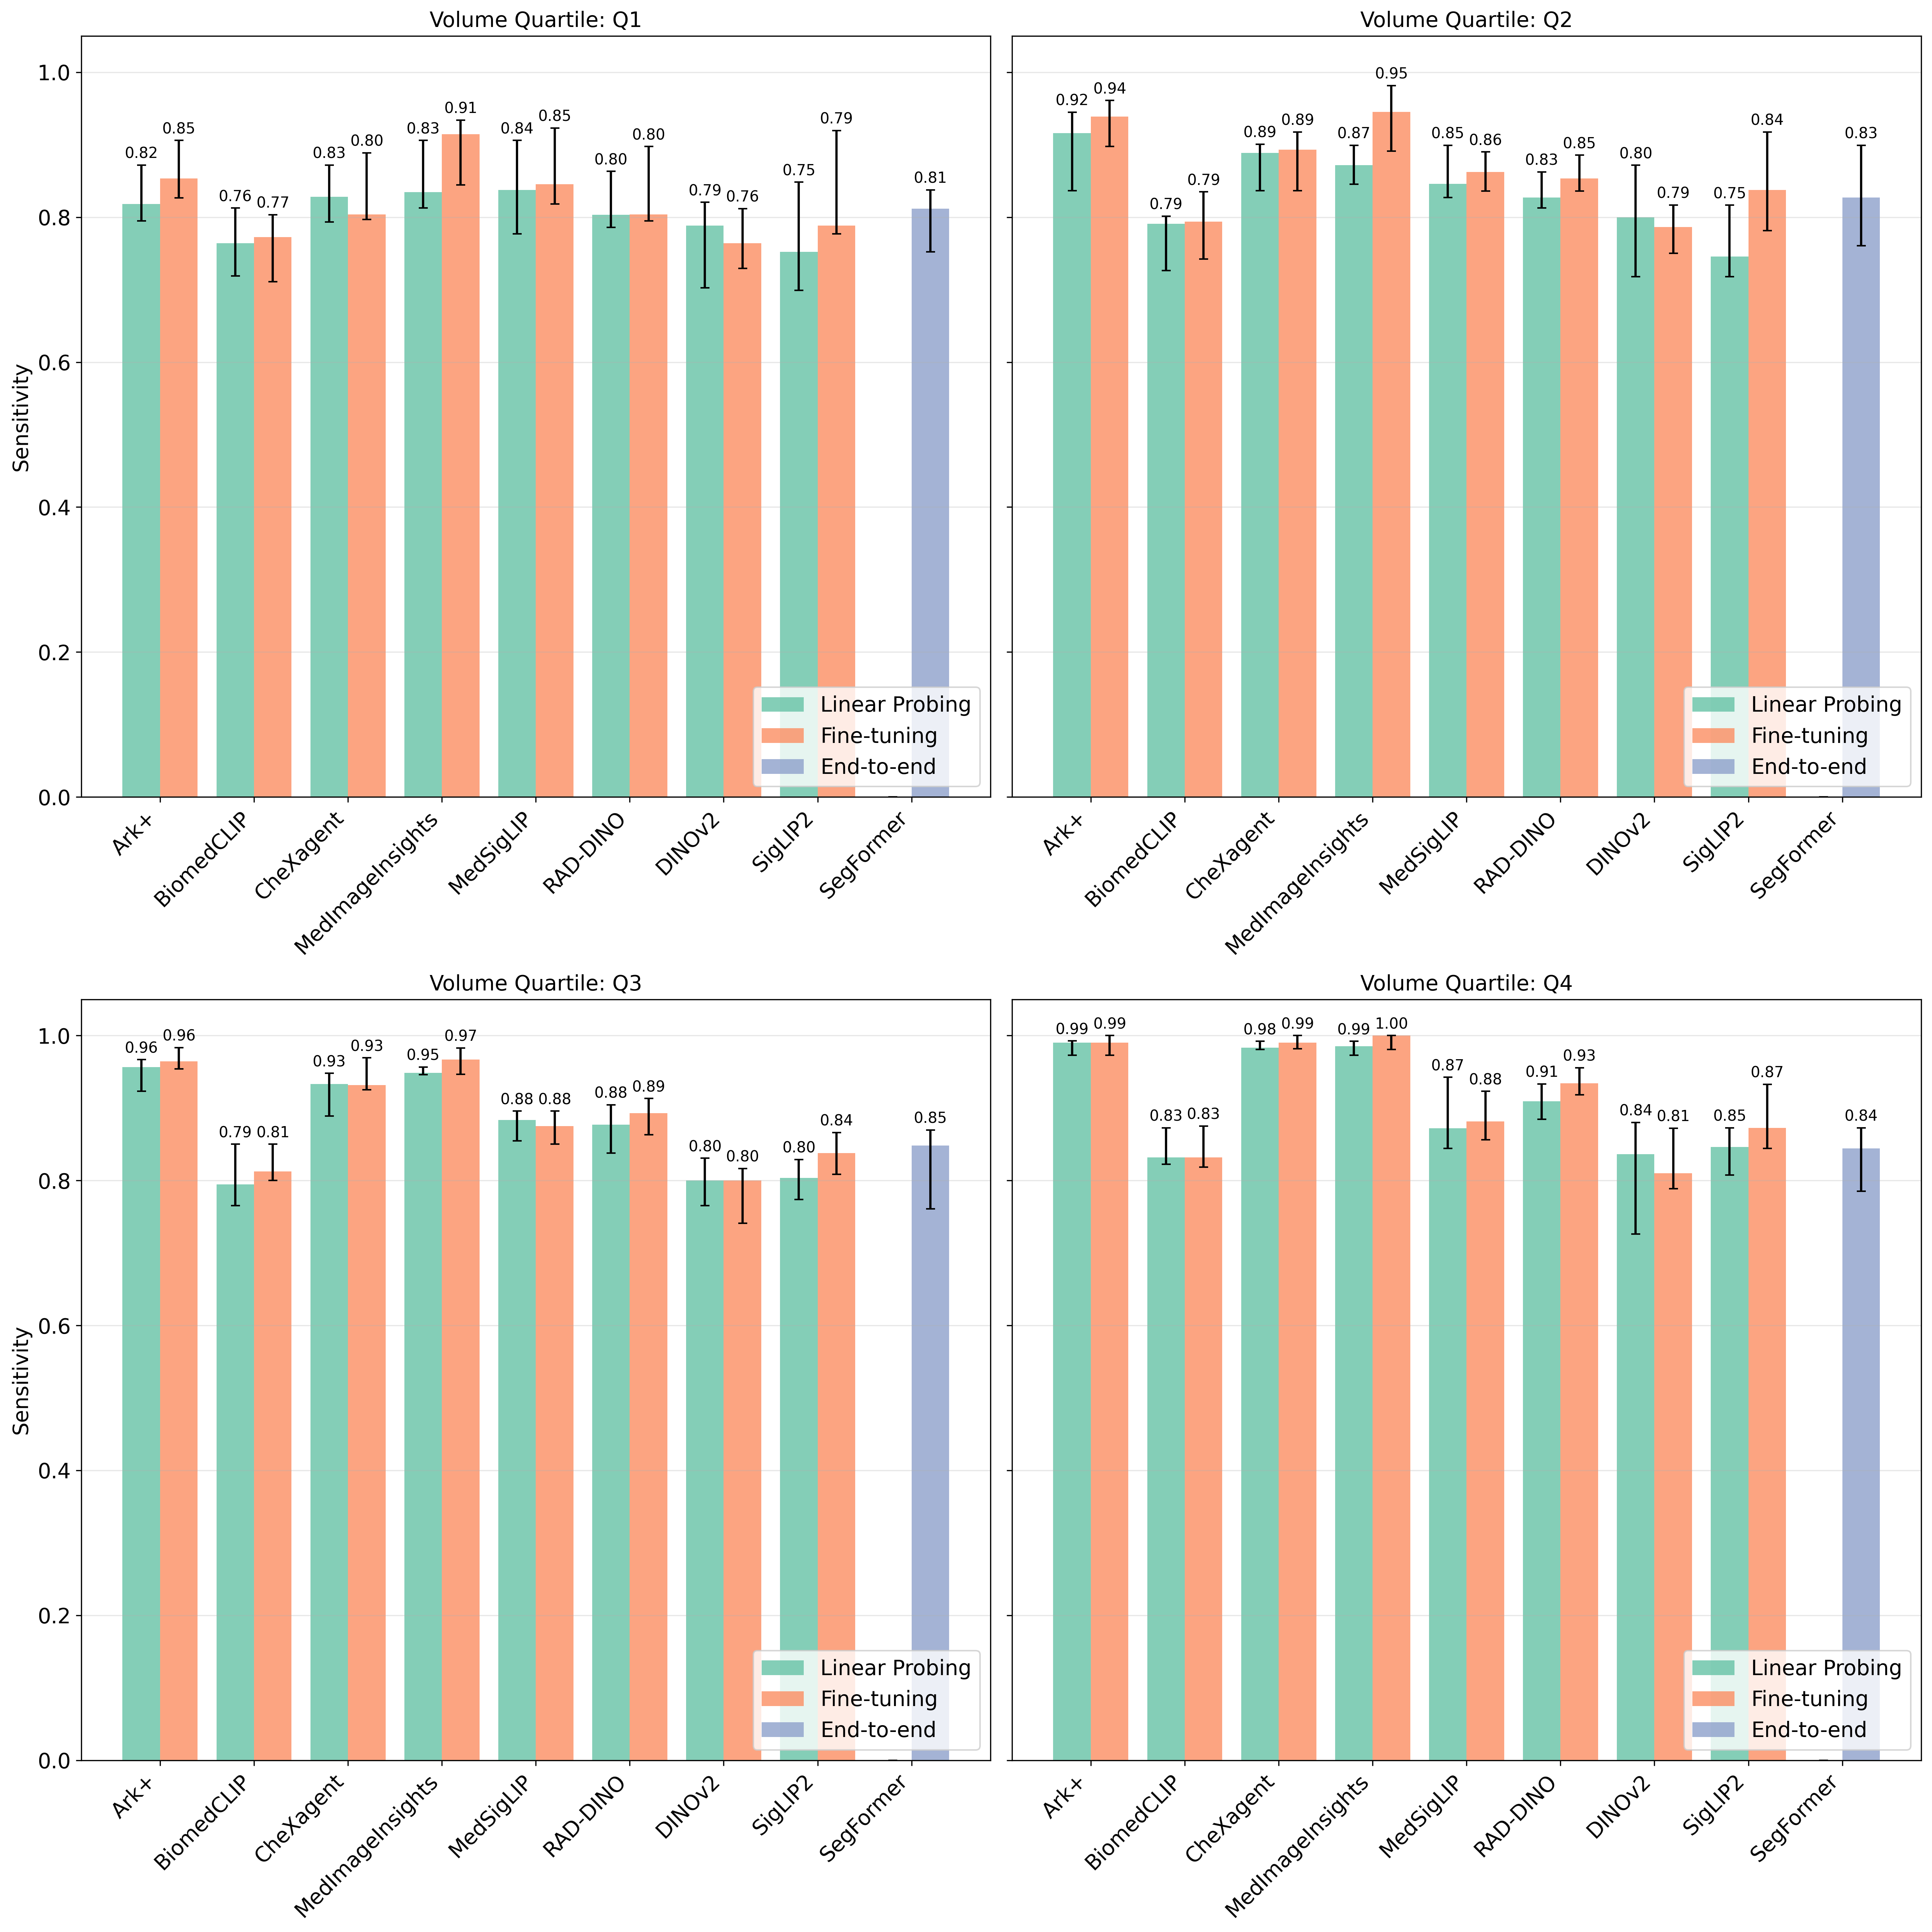

In [12]:
avg_sensitivity_vol = calculate_subgroup_metric_median_stats(df_sub, 'Volume Quartile', calculate_sensitivity, median_confidence_interval, metric_name='Sensitivity')

fig, axes = plot_metric_by_quartile(avg_sensitivity_vol, 'Sensitivity', figsize=(18, 18), palette='Set2', quartile_col='Volume Quartile', model_list=models, highlight_models='SegFormer', highlight_color=colors[2], highlight_label='End-to-end')
plt.show()


In [13]:
avg_sensitivity_vol_tube = calculate_subgroup_metric_median_stats(df_sub, 'Vol-Tube', calculate_sensitivity, median_confidence_interval, metric_name='Sensitivity')

fig, axes = plot_metric_by_quartile(avg_sensitivity_vol_tube, 'Sensitivity', figsize=(18, 36), palette='Set2', quartile_col='Vol-Tube', model_list=models, highlight_models='SegFormer', highlight_color=colors[2], highlight_label='End-to-end')
plt.show()

/mnt/NAS3/homes/fli40/FM_evaluation/utils/stats.py:163: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subgroup_metric = df_sub.groupby(['fold', 'model', 'freeze', groupby_column]).apply(metric_function)


In [14]:
df_sub.to_csv('./stats/4_1_cv_scores_cla_subgroup.csv', index=False)

In [15]:
avg_sensitivity_vol_tube['Sensitivity'] = avg_sensitivity_vol_tube.apply(lambda x: f'{x['Sensitivity']:.3f} ({x['ci_lower']:.3f}-{x['ci_upper']:.3f})', axis=1)
avg_sensitivity_vol_tube_e2e = avg_sensitivity_vol_tube[avg_sensitivity_vol_tube.freeze==0].drop(columns=['ci_lower','ci_upper','freeze'])
avg_sensitivity_vol_tube_fz = avg_sensitivity_vol_tube[avg_sensitivity_vol_tube.freeze==1].drop(columns=['ci_lower','ci_upper','freeze'])
avg_sensitivity_vol_tube_ = avg_sensitivity_vol_tube_fz.merge(avg_sensitivity_vol_tube_e2e, on=['model','Vol-Tube'], suffixes=['_LinearProbing','_Fine-tuning'], how='right')
avg_sensitivity_vol_tube_.to_csv('./stats/4_1_sensitivity_comparison_cla_subgroup.csv', index=False)
avg_sensitivity_vol_tube_

,model,Vol-Tube,Sensitivity_LinearProbing,Sensitivity_Fine-tuning
0,Ark+,Q1-0,0.483 (0.357-0.600),0.586 (0.536-0.720)
1,Ark+,Q1-1,0.939 (0.911-0.952),0.922 (0.902-0.964)
2,Ark+,Q2-0,0.780 (0.581-0.848),0.806 (0.760-0.939)
3,Ark+,Q2-1,0.968 (0.935-0.988),0.968 (0.935-0.988)
4,Ark+,Q3-0,0.867 (0.765-0.935),0.879 (0.853-0.935)
...,...,...,...,...
67,SigLIP2,Q2-1,0.884 (0.815-0.911),0.962 (0.916-0.976)
68,SigLIP2,Q3-0,0.545 (0.452-0.576),0.529 (0.467-0.636)
69,SigLIP2,Q3-1,0.899 (0.882-0.940),0.955 (0.929-0.964)
70,SigLIP2,Q4-0,0.605 (0.462-0.743),0.621 (0.564-0.781)


In [17]:
avg_sensitivity_vol_tube_[(avg_sensitivity_vol_tube_['Vol-Tube']=='Q1-0')|(avg_sensitivity_vol_tube_['Vol-Tube']=='Q1-1')].to_csv('./stats/4_1_Q1_cla.csv')